Significant features after FDR (q<0.05): 9s = 27, 30s = 25
Running cross-validation to get per-fold AUCs (this may take some time)...

AUC summary (mean ± std):
  9s LR: 0.5915 ± 0.0018
  9s RF: 0.7666 ± 0.0021
  30s LR: 0.6414 ± 0.0028
  30s RF: 0.8510 ± 0.0022


/tmp/ipykernel_2763261/672473721.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  b = plt.boxplot(data, labels=labels, patch_artist=True)


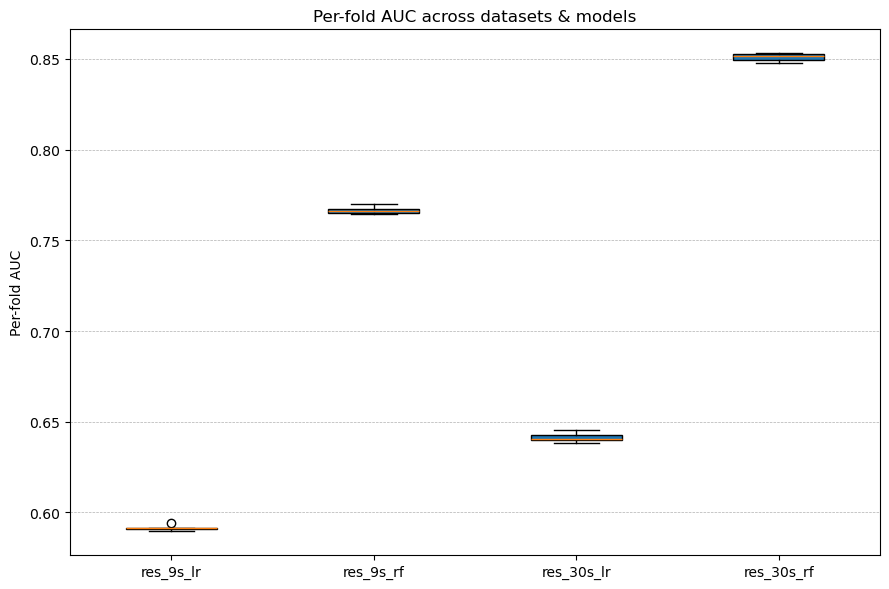

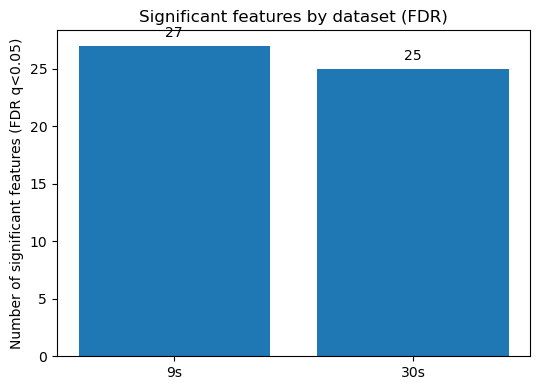

Saved: univariate_9s_results.csv, univariate_30s_results.csv, auc_summary.csv


In [1]:
# Jupyter cell: Compare 9s vs 30s feature sets (univariate FDR + per-fold AUC with LR & RF)
# Expectations: each CSV -> first 33 columns = features, last column = label ('Normal' or 'Apnea').

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from statsmodels.stats.multitest import multipletests
from scipy import stats
import matplotlib.pyplot as plt

# ----------------- USER PARAMETERS -----------------
path_9s_csv = "/scratch/sshuvo13/project_shared_folder_bspml_1/whole_dataset_features/train_test_separated_and_combined/female/33_features/train_data.csv"    # <- set path to your 9s CSV
path_30s_csv = "/scratch/sshuvo13/project_shared_folder_bspml_1/segments_30s/features/train_test_separated_and_combined/female/feature33/train_data.csv"  # <- set path to your 30s CSV
N_FEATURES_EXPECTED = 33           # first N columns are features
N_FOLDS = 5                        # number of CV folds (change to 10 if desired)
RANDOM_STATE = 42
# ---------------------------------------------------

def load_dataset(path, n_features_expected=N_FEATURES_EXPECTED):
    """Load CSV and return (X_df, y_array, feature_columns). Label 'Apnea' -> 1 else 0."""
    df = pd.read_csv(path)
    if df.shape[1] < 2:
        raise ValueError(f"File {path} has too few columns ({df.shape[1]}).")
    # last column is label
    label_col = df.columns[-1]
    # take first n_features_expected columns if present, else all except last
    if df.shape[1] >= n_features_expected + 1:
        feature_cols = list(df.columns[:n_features_expected])
    else:
        feature_cols = list(df.columns[:-1])
        print(f"Warning: {path} has {df.shape[1]} columns. Using {len(feature_cols)} features (all except last).")
    X = df[feature_cols].copy()
    y_raw = df[label_col].astype(str).str.strip().str.lower()
    y = (y_raw == 'apnea').astype(int).values
    return X, y, feature_cols

def univariate_tests_fdr(X, y, method='mannwhitney'):
    """Per-feature test between y==0 and y==1; returns DataFrame with p, fdr_q, significant boolean."""
    pvals = []
    stats_list = []
    for col in X.columns:
        a = X.loc[y==0, col].dropna().values
        b = X.loc[y==1, col].dropna().values
        if method == 't':
            try:
                stat, p = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
            except Exception:
                stat, p = np.nan, 1.0
        else:
            # Mann-Whitney U (non-parametric)
            try:
                stat, p = stats.mannwhitneyu(a, b, alternative='two-sided')
            except Exception:
                # fallback
                stat, p = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
        stats_list.append(stat)
        pvals.append(p if np.isfinite(p) else 1.0)
    # FDR correction (Benjamini-Hochberg)
    reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
    df_res = pd.DataFrame({
        'feature': list(X.columns),
        'statistic': stats_list,
        'pvalue': pvals,
        'pvalue_fdr': pvals_fdr,
        'significant_fdr': reject
    })
    return df_res

def auc_per_fold(X, y, model, n_splits=N_FOLDS, random_state=RANDOM_STATE):
    """Return array of per-fold AUCs using StratifiedKFold (shuffled)."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    aucs = cross_val_score(model, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
    return aucs

def run_analysis(path9, path30):
    # load
    X9, y9, feat9 = load_dataset(path9)
    X30, y30, feat30 = load_dataset(path30)
    # univariate tests + FDR
    uni9 = univariate_tests_fdr(X9, y9)
    uni30 = univariate_tests_fdr(X30, y30)
    count9 = int(uni9['significant_fdr'].sum())
    count30 = int(uni30['significant_fdr'].sum())
    print(f"Significant features after FDR (q<0.05): 9s = {count9}, 30s = {count30}")
    # models
    pipe_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=2000, solver='liblinear', random_state=RANDOM_STATE))
    ])
    rf = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)
    # per-fold AUCs
    print("Running cross-validation to get per-fold AUCs (this may take some time)...")
    aucs_9_lr  = auc_per_fold(X9,  y9,  pipe_lr)
    aucs_9_rf  = auc_per_fold(X9,  y9,  rf)
    aucs_30_lr = auc_per_fold(X30, y30, pipe_lr)
    aucs_30_rf = auc_per_fold(X30, y30, rf)
    # summary
    summary = pd.DataFrame({
        'dataset': ['9s','9s','30s','30s'],
        'model': ['LR','RF','LR','RF'],
        'mean_auc': [aucs_9_lr.mean(), aucs_9_rf.mean(), aucs_30_lr.mean(), aucs_30_rf.mean()],
        'std_auc': [aucs_9_lr.std(ddof=1), aucs_9_rf.std(ddof=1), aucs_30_lr.std(ddof=1), aucs_30_rf.std(ddof=1)],
        'per_fold_aucs': [aucs_9_lr, aucs_9_rf, aucs_30_lr, aucs_30_rf]
    })
    print("\nAUC summary (mean ± std):")
    for idx, row in summary.iterrows():
        print(f"  {row['dataset']} {row['model']}: {row['mean_auc']:.4f} ± {row['std_auc']:.4f}")
    # Boxplot: 4 boxes (res_9s_lr, res_9s_rf, res_30s_lr, res_30s_rf)
    plt.figure(figsize=(9,6))
    data = [aucs_9_lr, aucs_9_rf, aucs_30_lr, aucs_30_rf]
    labels = ['res_9s_lr', 'res_9s_rf', 'res_30s_lr', 'res_30s_rf']
    b = plt.boxplot(data, labels=labels, patch_artist=True)
    plt.ylabel('Per-fold AUC')
    plt.title('Per-fold AUC across datasets & models')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    # Bar plot: number of significant features (FDR) for 9s and 30s
    plt.figure(figsize=(5.5,4))
    counts = [count9, count30]
    bars = plt.bar(['9s','30s'], counts)
    plt.ylabel('Number of significant features (FDR q<0.05)')
    plt.title('Significant features by dataset (FDR)')
    # add text labels
    for i, v in enumerate(counts):
        plt.text(i, v + max(counts)*0.02 if max(counts)>0 else 0.02, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    # Save CSVs for inspection
    uni9.to_csv("univariate_9s_results.csv", index=False)
    uni30.to_csv("univariate_30s_results.csv", index=False)
    summary.to_csv("auc_summary.csv", index=False)
    print("Saved: univariate_9s_results.csv, univariate_30s_results.csv, auc_summary.csv")
    # Return results dictionary
    return {
        'uni9': uni9,
        'uni30': uni30,
        'counts': {'9s': count9, '30s': count30},
        'aucs': {
            'res_9s_lr': aucs_9_lr,
            'res_9s_rf': aucs_9_rf,
            'res_30s_lr': aucs_30_lr,
            'res_30s_rf': aucs_30_rf
        },
        'summary': summary
    }

if not os.path.exists(path_9s_csv):
    raise FileNotFoundError(f"9s CSV not found at: {path_9s_csv}")
if not os.path.exists(path_30s_csv):
    raise FileNotFoundError(f"30s CSV not found at: {path_30s_csv}")

results = run_analysis(path_9s_csv, path_30s_csv)

# Access per-fold AUC arrays as:
# results['aucs']['res_9s_lr'], results['aucs']['res_9s_rf'], results['aucs']['res_30s_lr'], results['aucs']['res_30s_rf']
